In [1]:
import os
os.chdir('..')

In [2]:
import json
import numpy as np
import torch
from tqdm.auto import tqdm
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from modeling import get_model
from diffusion.scheduler import get_scheduler
from diffusion.sampler import get_sampler
from utils import count_parameters

%matplotlib inline
sns.set_style('darkgrid')

In [3]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [4]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms.functional as TF

def get_dataset(dataset_type):
    ds_class = MNIST if dataset_type == 'mnist' else CIFAR10
    transform = T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)])
    ds = ds_class('~/datasets', download=True, transform=transform)
    return ds

In [5]:
def tensor2image(tensor, value_range=None, resize_factor=None):
    if value_range is not None:
        tensor = (tensor - value_range[0]) / (value_range[1] - value_range[0])
    tensor = tensor.clamp(0, 1)
    image = to_pil_image(tensor)
    if resize_factor is not None:
        new_size = (int(image.width * resize_factor), int(image.height * resize_factor))
        image = image.resize(new_size, resample=Image.NEAREST)
    return image

In [6]:
def load_ckpt(ckpt_dir, ckpt_name, ema=True, device='cpu'):
    with open(os.path.join(ckpt_dir, 'train_args.json'), 'r') as f:
        train_args = json.load(f)

    model = get_model(train_args['model_type'], **train_args['model_cfg'])
    ckpt_path = os.path.join(
        ckpt_dir, 'ckpts', ckpt_name, 
        'ema_model.pt' if ema else 'model.pt'
    )
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)

    scheduler = get_scheduler(train_args['scheduler_type'], **train_args['scheduler_cfg'])
    sampler = get_sampler(train_args['sampler_type'], **train_args['sampler_cfg'])

    return model, scheduler, sampler, train_args['dataset']

In [ ]:
sampling_steps = 100
# model, scheduler, sampler, dataset_type = load_ckpt('outputs/cos_mnist_base', 'ckpt-080000')
# model, scheduler, sampler, dataset_type = load_ckpt('outputs/beta_mnist_base', 'ckpt-150000')
# model, scheduler, sampler, dataset_type = load_ckpt('outputs/beta_cifar10_base', 'ckpt-180000')
model, scheduler, sampler, dataset_type = load_ckpt('outputs/cos_cifar10_base', 'ckpt-090000')
sampler.set_steps(sampling_steps)
model.eval()
model.to(device)
pred_fn = model.get_pred_fn()
count_parameters(model)

55869187

In [8]:
if dataset_type == 'mnist':
    image_shape = (1, 28, 28)
elif dataset_type == 'cifar10':
    image_shape = (3, 32, 32)
else:
    raise ValueError(f"Unknown dataset type: {dataset_type}")
dataset = get_dataset(dataset_type)

/home/jimyeong/.conda/envs/ddpm/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [9]:
from diffusion.sampler import BaseSampler

class CustomDDIMSampler(BaseSampler):
    def __init__(self, n_steps, clip_latent=True, pbar=False, pbar_kwargs=None):
        super().__init__(n_steps, pbar, pbar_kwargs)
        self.clip_latent = clip_latent
    
    def get_timesteps(self, scheduler):
        return torch.linspace(
            scheduler.n_steps - 1, 0,
            steps=self.n_steps + 1,
            dtype=torch.int64
        )[:-1]
    
    @torch.no_grad()
    def sample(
            self, 
            z: torch.Tensor, scheduler, pred_fn, 
            initial_timestep=None,
            final_timestep=None,
            verbose=False,
    ):
        t_steps = self.get_timesteps(scheduler).to(z.device)

        start_idx = 0
        if initial_timestep is not None:
            assert (t_steps == initial_timestep).any().item(), "initial_timestep must be in t_steps"
            start_idx = (t_steps == initial_timestep).nonzero(as_tuple=True)[0].item()
        end_idx = len(t_steps)
        if final_timestep is not None:
            assert (t_steps == final_timestep).any().item(), "final_timestep must be in t_steps"
            end_idx = (t_steps == final_timestep).nonzero(as_tuple=True)[0].item()
        
        if verbose:
            print(f"Using t_steps: {t_steps[start_idx:end_idx].cpu().numpy()}")

        iterator = self.prepare_iterator(range(start_idx, end_idx))
        for i in iterator:
            eps_pred = pred_fn(z, t_steps[i].repeat(z.size(0)))
            t = scheduler.get_schedule(t_steps[i])

            alpha_t_ = torch.sqrt(t.alpha_sq).to(z.dtype)
            sigma_t_ = torch.sqrt(t.sigma_sq).to(z.dtype)
            x0_pred = (z - sigma_t_ * eps_pred) / alpha_t_
            if verbose:
                print(f"t={t_steps[i].item()}: alpha={alpha_t_.item():.4f}, sigma={sigma_t_.item():.4f}, x0_pred [{x0_pred.min().item():.4f}, {x0_pred.max().item():.4f}], eps_pred [{eps_pred.min().item():.4f}, {eps_pred.max().item():.4f}]")
            if self.clip_latent:
                x0_pred = torch.clip(x0_pred, -1, 1)

            if i < len(t_steps) - 1:
                t_prime = scheduler.get_schedule(t_steps[i + 1])

                alpha_t_prime_ = torch.sqrt(t_prime.alpha_sq).to(z.dtype)
                sigma_t_prime_ = torch.sqrt(t_prime.sigma_sq).to(z.dtype)
                z = alpha_t_prime_ * x0_pred + sigma_t_prime_ * eps_pred

            else:
                z = x0_pred

        return z

In [10]:
sampler = CustomDDIMSampler(n_steps=100, pbar=False, clip_latent=True)
timesteps = sampler.get_timesteps(scheduler)
print(timesteps.numpy())

[999 989 979 969 959 949 939 929 919 909 899 889 879 869 859 849 839 829
 819 809 799 789 779 769 759 749 739 729 719 709 699 689 679 669 659 649
 639 629 619 609 599 589 579 569 559 549 539 529 519 509 499 489 479 469
 459 449 439 429 419 409 399 389 379 369 359 349 339 329 319 309 299 289
 279 269 259 249 239 229 219 209 199 189 179 169 159 149 139 129 119 109
  99  89  79  69  59  49  39  29  19   9]


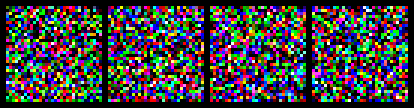

In [11]:
seed = 123
batch_size = 4
gen = torch.Generator().manual_seed(seed)
z = torch.randn((batch_size, *image_shape), generator=gen)
tensor2image(make_grid(z, nrow=4, value_range=(-1, 1)), resize_factor=3)

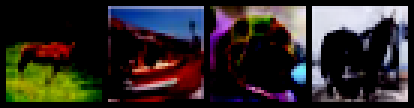

In [12]:
sampled = sampler.sample(z.to(device), scheduler, pred_fn, verbose=False)
tensor2image(make_grid(sampled.cpu(), nrow=4, value_range=(-1, 1)), resize_factor=3)

In [26]:
step_size = 10
intermediate_results = []
ed_steps = []
last = z.clone().to(device)
for i in range(0, len(timesteps), step_size):
    st = timesteps[i].item()
    ed = None
    if i + step_size < len(timesteps):
        ed = timesteps[i + step_size].item()
        ed_steps.append(ed)
    last = sampler.sample(last, scheduler, pred_fn, initial_timestep=st, final_timestep=ed)
    intermediate_results.append(last.clone().cpu())
last = last.cpu()
intermediate_results.pop()
intermediate_results = torch.stack(intermediate_results)
n = len(ed_steps) + 2
print(intermediate_results.shape)


torch.Size([9, 4, 3, 32, 32])


In [27]:
show = step_size >= 10
def show_tr(img_tensor, nr, value_range=(-1, 1), resize_factor=3):
    if not show:
        return
    grid = make_grid(img_tensor.transpose(0, 1).reshape(-1, *image_shape), nrow=nr, value_range=value_range)
    display(tensor2image(grid, resize_factor=resize_factor))

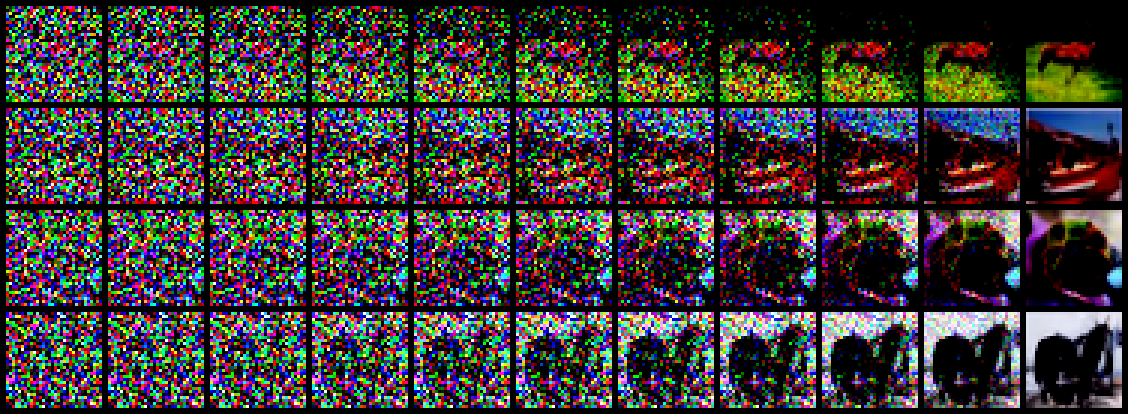

In [28]:
im = torch.cat([z.unsqueeze(0), intermediate_results, last.unsqueeze(0)], dim=0)
reverse = im.clone()
show_tr(reverse, nr=n)

In [29]:
perturbed = last.unsqueeze(1).repeat_interleave(n-2, dim=1).transpose(0, 1).reshape(-1, *image_shape)
noise = z.repeat_interleave(n-2, dim=0)
perturb_steps = torch.tensor(ed_steps).repeat_interleave(batch_size)
perturbed = scheduler.diffuse(perturbed, perturb_steps, noise).reshape(n-2, batch_size, *image_shape)
perturbed.shape

torch.Size([9, 4, 3, 32, 32])

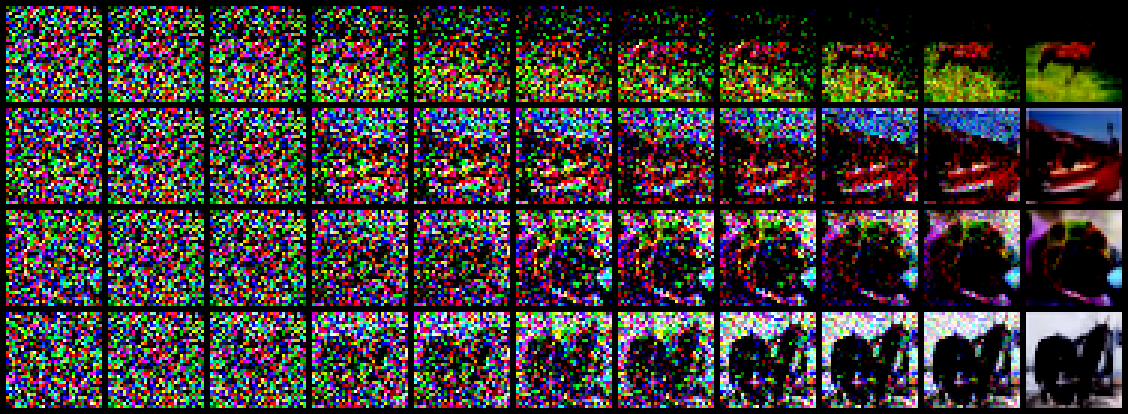

In [30]:
im = torch.cat([z.unsqueeze(0), perturbed, last.unsqueeze(0)], dim=0)
forward = im.clone()
show_tr(forward, nr=n)

In [31]:
(forward - reverse).abs().mean(dim=[0, 2, 3, 4])

tensor([0.3181, 0.3724, 0.4436, 0.5195])

In [32]:
sc = scheduler.get_schedule(torch.tensor(ed_steps))
sc.alpha_sq

tensor([0.0241, 0.0940, 0.2031, 0.3408, 0.4938, 0.6475, 0.7869, 0.8987, 0.9721],
       dtype=torch.float64)

torch.Size([9, 4, 3, 32, 32])
torch.Size([9, 4, 3, 32, 32])


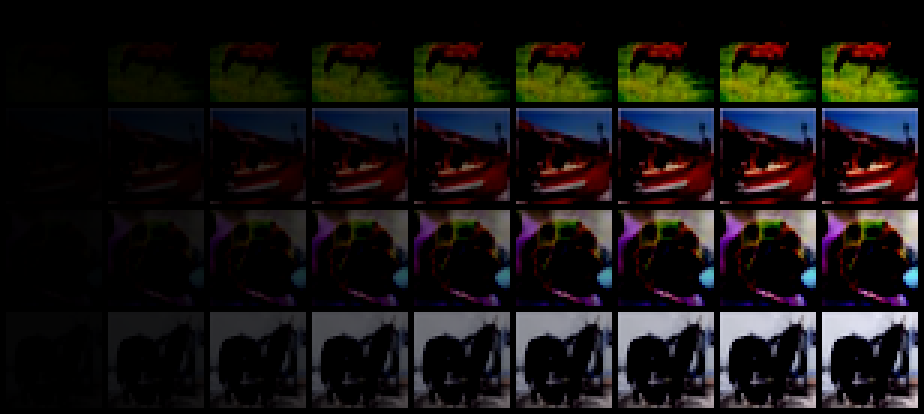

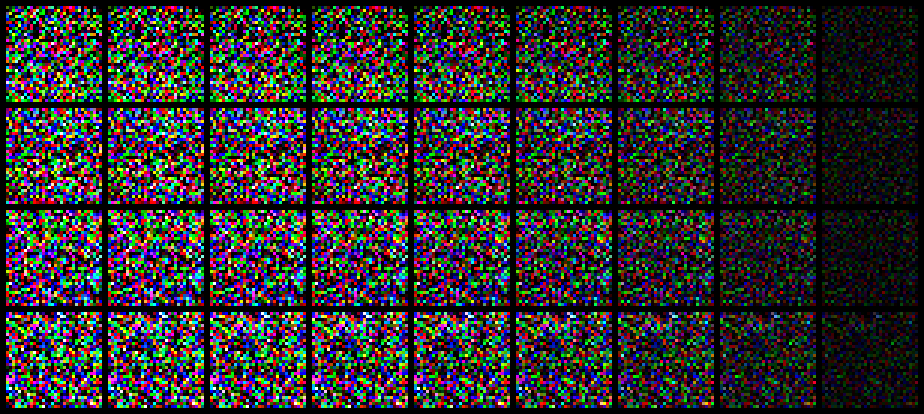

In [33]:
last_alpha = sc.alpha_sq.view(-1, 1, 1, 1, 1) * last.unsqueeze(0)
print(last_alpha.shape)
tmp = intermediate_results - last_alpha
print(tmp.shape)
show_tr(last_alpha, nr=n-2)
show_tr(tmp, nr=n-2)

In [34]:
noise_scale = torch.std(tmp, dim=(2,3,4)).mean(dim=1) ** 2
empirical_log_snr = torch.log(sc.alpha_sq / noise_scale)
empirical_log_snr

tensor([-3.7197, -2.2806, -1.3723, -0.6471,  0.0150,  0.6844,  1.4308,  2.3724,
         3.8468], dtype=torch.float64)

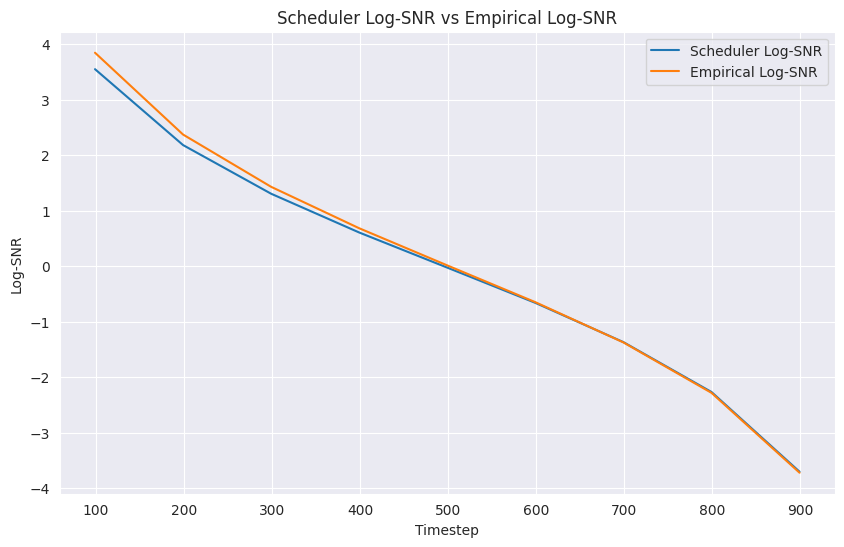

In [35]:
# plot scheduler log-snr and empirical log-snr\
plt.figure(figsize=(10, 6))
plt.plot(ed_steps, sc.log_snr.cpu().numpy(), label='Scheduler Log-SNR')
plt.plot(ed_steps, empirical_log_snr.cpu().numpy(), label='Empirical Log-SNR')
plt.xlabel('Timestep')
plt.ylabel('Log-SNR')
plt.title('Scheduler Log-SNR vs Empirical Log-SNR')
plt.legend()
plt.show()

In [23]:
# z_0 = last.clone().reshape(batch_size, -1)
# z_T = z.clone().reshape(batch_size, -1)
# z_0.shape, z_T.shape

In [24]:
# for i in range(len(ed_steps)-1):
#     # z_t = intermediate_results[i].reshape(batch_size, -1)
#     z_t = perturbed[i].reshape(batch_size, -1)
#     signal = ((z_0 * z_t).sum(dim=1, keepdim=True) / z_0.norm(dim=1, keepdim=True)) * z_0
#     noise = z_t - signal
#     print(f'signal norm: {signal.norm(dim=1)}, noise norm: {noise.norm(dim=1)}')
#     snr = (signal.norm(dim=1) / noise.norm(dim=1)) ** 2
#     log_snr = torch.log(snr)
#     print(snr, log_snr)

In [25]:
# for j in range(len(ed_steps)-1):
#     # z_t = intermediate_results[j].reshape(batch_size, -1)
#     z_t = perturbed[j].reshape(batch_size, -1)
#     snrs = []
#     thetas = []
#     for i in range(batch_size):
#         X, Y, Z = z_0[i], z_T[i], z_t[i]
#         def error(theta):
#             return (X*np.sin(theta) + Y*np.cos(theta) - Z).norm(dim=-1)
#         # get theta that minimizes error
#         from scipy.optimize import minimize
#         theta_init = 0
#         res = minimize(lambda tt: error(tt).item(), 0.5)
#         theta_opt = res.x[0]
#         thetas.append(theta_opt)
#         snr = np.cos(theta_opt) / np.sin(theta_opt)
#         snrs.append(snr)
#     snrs = torch.tensor(snrs, dtype=torch.float32)
#     log_snrs = torch.log(snrs)
#     print(snrs, log_snrs, thetas)